In [56]:
import pennylane as qml
import tensorflow as tf
import numpy as np
import keras

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sklearn as sks

## Load the Dataset

In [5]:
X, y = sks.datasets.make_moons(n_samples=200, noise=0.2, random_state=42)

In [12]:
y.shape

(200,)

In [11]:
X.shape

(200, 2)

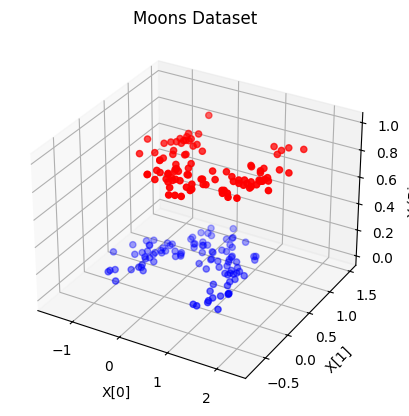

In [26]:
colors = np.where(y == 1, 'red', 'blue') # Assign 'red' for y=1, 'blue' for y=0

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0],X[:,1],y, c=colors)
ax.set_xlabel('X[0]')
ax.set_ylabel('X[1] ')
ax.set_zlabel('Y (Binary)')
ax.set_title('Moons Dataset')
plt.show()

## The Variational Circuit

### Defining Circuit Parameters

The variational circuit is defined based on 2 parameters:
* The number of layers ($l$)
* The number of input variables or qubits ($q$)

In [30]:
layers = 4
qubits = X.shape[-1]

We create the weight matrix based on the parameters described earlier. Each layer is applied per qubit, and each qubit needs 3 parameters for the `qml.Rot` gate. Therefore we get a weight matrix of the shape $(l,q,3)$. 

`np.random.rand` creates random values $\in [0,1)$, however we want the periodic range of our rotational gates, therefore we multiply the weights by $2\pi$.

In [33]:
w = np.random.rand(layers,qubits,3)*2*np.pi
print(w.shape)

(4, 2, 3)


The weights are wrapped into a tensorflow variable for training

In [36]:
weights = tf.Variable(w)
print(weights.shape)

(4, 2, 3)


We can now define our pennylane device based on the number of qubits. We use the `lightning.qubit` backend for better performance.

### Creating the Circuit

In [37]:
dev = qml.device('lightning.qubit',wires=qubits)

We now create the actual circuit based on the parameters. Keep in mind the following points:
1. The `qml.qnode` decorator is important for the circuit to be runnable in pennylane
2. The `interface` argument of the qnode should match the library used
3. The order of input arguments is **important** as pennylane always assumes the last argument to be the data for batching reasons

In [55]:
@qml.qnode(dev,interface='tf') # Define the pennylane qnode wrapper
def variational_model(weights,x): 
    for q in range(weights.shape[1]):
        qml.RY(x[:,q],wires=q)
    for w in weights:
        for q in range(w.shape[0]):
            qml.Rot(*w[q],wires=q)
    return [qml.expval(qml.Z(q)) for q in range(weights.shape[1])] ## Measure the expval for each qubit

We can visualize the circuit below

(<Figure size 800x300 with 1 Axes>, <Axes: >)

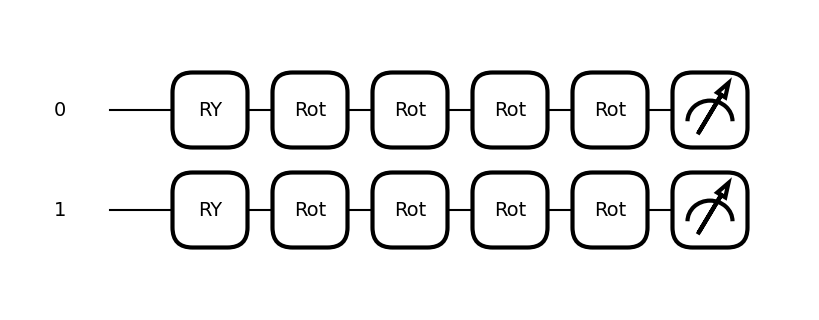

In [54]:
qml.draw_mpl(variational_model)(weights,X[:2])

## Training the model